In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
from io import IncrementalNewlineDecoder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
#Convert MNIST image files into a 4D-Tensor (No. of images, height, width, color channel)
transform = transforms.ToTensor()

In [4]:
#Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 481663070.36it/s]

Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 122359286.69it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 199598585.72it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17116378.05it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [5]:
#Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data

NameError: name 'test_data' is not defined

In [6]:
#We need loader for our data.
#Create a small batch size of images (size=10)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)



In [7]:
#Define our CNN model--> 2d convo model
#Model asks for the following parameters (in_channels: int, out_channels: int, kernel_size: _size_2_t, stride)
#Describe convolutional layer and what its doing (2 C-layers)-->
# This is just an example. We'll build the actual model later

conv1 = nn.Conv2d(1,6,3,1)      # 1 input ch, 6 output ch, kernel size: 3x3, stride:1
#conv2 = nn.Conv2d(6,16,3,1)      # 6 outputs in the previous layer become 6 inputs for this layer # Output ch here can be taken as anything
conv2 = nn.Conv2d(6, 16, 3, 1)  # Corrected weight tensor dimensions: [16, 6, 3, 3]




In [8]:
# Grab 1 MNIST record or image
for i, (x_train, y_train) in enumerate(train_data):
  break

In [ ]:
x_train.shape

torch.Size([1, 28, 28])

In [9]:
#Changing into 4D
x = x_train.view(1,1,28,28)  # 1 batch of 1 image, 28x28 size


In [10]:
#Perform our first convolution
x = F.relu(conv1(x))                  #Rectified linear unit for our activation function


In [ ]:
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# In the previous output, 1 image, 6 filters, 28x28 reduces to 26x26 cz outer layer got dropped from all sides
# bcz we did set the padding in --> #conv2 = nn.Conv2d(6,16,3,1) command


In [11]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2)    #Kernel=2; Stride=2

In [ ]:
x.shape

torch.Size([1, 6, 13, 13])

In [12]:
# 26/2
# 2nd convolutional layer
x = F.relu(conv2(x))

In [ ]:
x.shape

torch.Size([1, 16, 11, 11])

In [13]:
# 2 pixels dropped again bcz padding wasn't set
# 2 Pooling layer
x = F.max_pool2d(x, 2, 2)

In [ ]:
x.shape

torch.Size([1, 16, 5, 5])

In [41]:
# 11/2=5.5, rounding down=5


In [14]:
#Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3 ,1)               # Same as above   (Input, Output, Kernel, Stride)
    self.conv2 = nn.Conv2d(6 ,16, 3, 1)              # Same as above
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)                     # torch.Size([1, 16, 5, 5])  # 120 is a random figure
    self.fc2 = nn.Linear(120, 84)
    self.out = nn.Linear(84, 10 )

  def forward(self, x):                               # Push forward
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)                          #2x2 Kernel;stride=2

    # 2nd pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)

    #Re-view to flatten it out
    x = x.view(-1, 16*5*5)                          # -1 to vary the batch size

    # Fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return F.log_softmax(x, dim=1)                  #Dimension=1





In [15]:
#Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      #Smaller the learning rate, longer it takes the model to take

In [17]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5                           # No. of cycles of training
train_losses = []
train_correct = []
test_losses = []
test_correct = []

# For loop for epochs
for i  in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (x_train, y_train) in enumerate(train_loader):
    b+=1                                                       # Start our batches at 1
    y_pred = model(x_train)                                    # Get predicted value from the training set in 2d form bcz conv variables are 2d
    loss = criterion(y_pred, y_train)                          # How far are we? Comparing predictions with correct answers in y_train
    predicted = torch.max(y_pred.data, 1)[1]                   # Add up the no. of correct predictions. Indexed off the 1st point
    batch_corr = (predicted == y_train).sum()                  # How many correct from this batch. True=1, False=0. Sum it up
    trn_corr += batch_corr                                     # Total correct in trainings

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print results
    if b%600 == 0:
      print(f'Epoch:{i} Batch:{b} Loss:{loss.item()} ')


  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():                    # No gardient cz we dont update model weights using test data
    for b, (x_test, y_test) in enumerate(test_loader):
      y_val = model(x_test)
      predicted = torch.max(y_val.data, 1 )[1]           # Adding up correct predictions
      tst_corr += (predicted == y_test).sum()            # T=1, F=0. Sum up

      loss = criterion(y_val, y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)


current_time = time.time()
Total = current_time - start_time
print(f'The training took: {Total/60} minutes!! \t Loda le lo')

Epoch:0 Batch:600 Loss:0.1599934995174408 
Epoch:0 Batch:1200 Loss:0.18979528546333313 
Epoch:0 Batch:1800 Loss:0.5580862760543823 
Epoch:0 Batch:2400 Loss:0.2070152312517166 
Epoch:0 Batch:3000 Loss:0.006888664327561855 
Epoch:0 Batch:3600 Loss:0.33112621307373047 
Epoch:0 Batch:4200 Loss:0.004664934705942869 
Epoch:0 Batch:4800 Loss:0.0020317500457167625 
Epoch:0 Batch:5400 Loss:0.06558699160814285 
Epoch:0 Batch:6000 Loss:0.000513441045768559 
Epoch:1 Batch:600 Loss:0.004773168824613094 
Epoch:1 Batch:1200 Loss:0.30684694647789 
Epoch:1 Batch:1800 Loss:0.0025840331800282 
Epoch:1 Batch:2400 Loss:0.004851708188652992 
Epoch:1 Batch:3000 Loss:0.05095291882753372 
Epoch:1 Batch:3600 Loss:0.29904529452323914 
Epoch:1 Batch:4200 Loss:0.020275484770536423 
Epoch:1 Batch:4800 Loss:0.0018002415308728814 
Epoch:1 Batch:5400 Loss:0.0003511425748001784 
Epoch:1 Batch:6000 Loss:0.16817066073417664 
Epoch:2 Batch:600 Loss:0.044435493648052216 
Epoch:2 Batch:1200 Loss:0.004347414709627628 
Epoch:

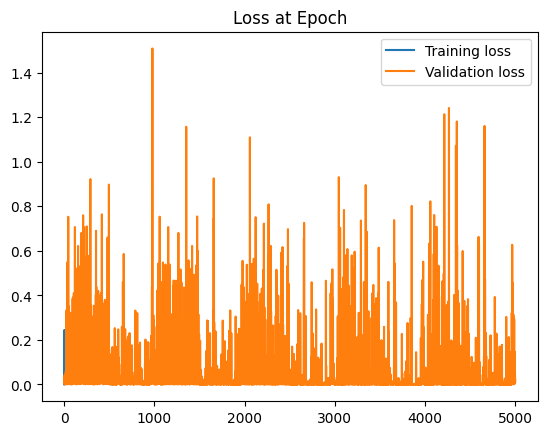

In [22]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]     # Tensor to numpy
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at Epoch')
plt.legend()


In [18]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for x_test, y_test in test_load_everything:
    y_val = model(x_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

correct.item()/len(test_data)*100               # % Accuracy


98.86

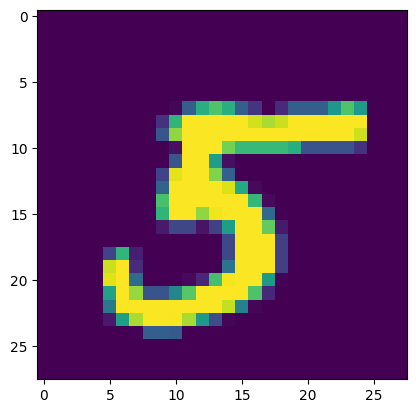

In [30]:
# Grab an image
# test_data[1321]             # Gives tensor with an image. At the end, it will show label

# Grab just the data, without label
#test_data[1321][0]

# Reshape it
test_data[9988][0].reshape(28, 28)                # reshape the image into a 28x28

# Show image
plt.imshow(test_data[9988][0].reshape(28, 28))

# Pass the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[9988][0].view(1,1,28, 28))   # Batch size=1, 1 colour channel, 28x28


In [31]:
new_prediction

tensor([[-2.9149e+01, -3.3785e+01, -3.8868e+01, -1.8524e+01, -3.3785e+01,
         -1.1921e-07, -2.0865e+01, -3.2221e+01, -1.6660e+01, -1.5656e+01]])

In [32]:
new_prediction.argmax()

tensor(5)